In [60]:
import pandas as pd
from math import sqrt;
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression;
from sklearn.metrics import accuracy_score, r2_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, f1_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import joblib

In [61]:
#Importing Datasets 
malicious_dataset = pd.read_csv('malicious_flows.csv')
benign_dataset = pd.read_csv('sample_benign_flows.csv')

# Removing duplicated rows from benign_dataset (5380 rows removed)
benign_dataset = benign_dataset[benign_dataset.duplicated(keep=False) == False]

# Combining both datasets together
all_flows = pd.concat([malicious_dataset, benign_dataset])

# Reducing the size of the dataset to reduce the amount of time taken in training models
reduced_dataset = all_flows.sample(25000)

#removing nan values
df = reduced_dataset.drop(reduced_dataset.columns[np.isnan(reduced_dataset).any()], axis=1)

reduced_y=df['isMalware']
reduced_x=df.drop(['isMalware'], axis=1)

In [62]:
#Showing information 
reduced_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 4079 to 17826
Columns: 504 entries, Src_Port to 99
dtypes: float64(133), int64(371)
memory usage: 96.3 MB


In [63]:
reduced_dataset.head()

,Src_Port,Dst_Port,Bytes_in,Bytes_out,Pkts_in,Pkts_out,entropy,byte_dist_std,byte_dist_mn,num_of_exts,...,90,91,92,93,94,95,96,97,98,99
4079,49341,443,1060,545,7,8,7.564174,58.004306,99.193769,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8795,40613,443,1827,634,7,15,7.719059,61.986012,107.399837,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8199,37523,443,1737,1063,7,15,3.978356,56.481778,92.933571,7,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3285,44833,443,1736,1101,7,15,4.002285,56.985548,96.539302,7,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
24252,41971,8443,1738,643,8,15,7.745308,60.455713,111.257875,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# Splitting datasets into training and test data
x_train, x_test, y_train, y_test = train_test_split(reduced_x, reduced_y, test_size=0.2, random_state=42)

In [65]:
# Training random forest classifier
rf_clf = RandomForestClassifier(max_depth=100)
rf_clf.fit(x_train, y_train) 
rf_prediction = rf_clf.predict(x_test)
conf_m = confusion_matrix(y_test, rf_prediction)  
print('Random Forest Classifier Accuracy score: ', accuracy_score(y_test, rf_prediction))

Random Forest Classifier Accuracy score:  0.9986


In [66]:
#Function to plot most import features of random forest model
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sn.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.ylim(0, 50)
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

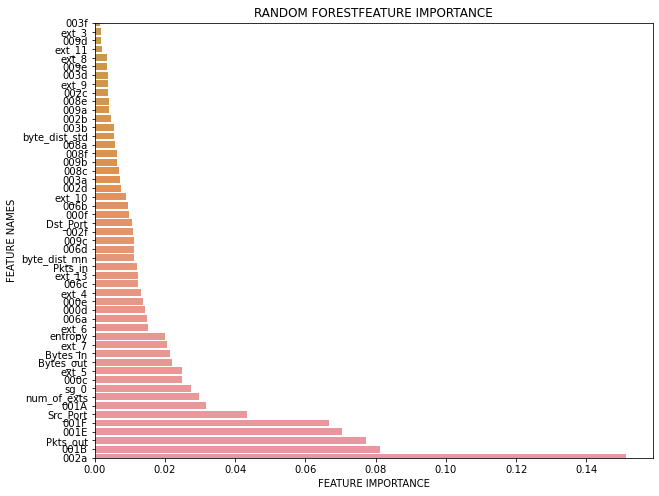

In [67]:
plot_feature_importance(rf_clf.feature_importances_,x_train.columns,'RANDOM FOREST') 

/Users/megencochran/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


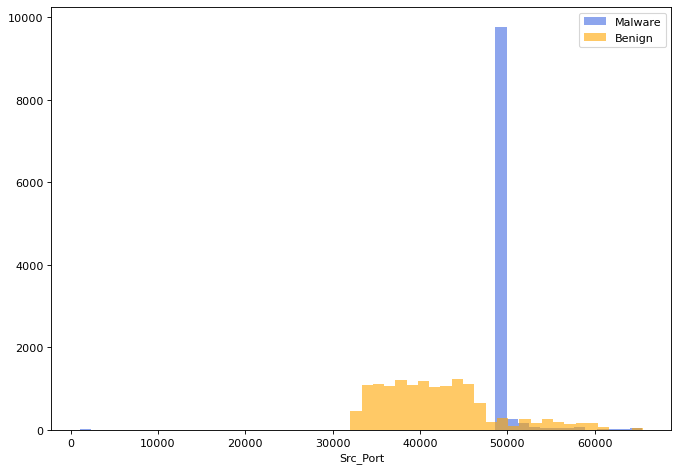

In [68]:
x1 = reduced_dataset.loc[reduced_dataset.isMalware==1, 'Src_Port']
x2 = reduced_dataset.loc[reduced_dataset.isMalware==0, 'Src_Port']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sn.distplot(x1, color="royalblue", label="Malware", **kwargs, kde=False)
sn.distplot(x2, color="orange", label="Benign", **kwargs, kde=False)

plt.legend();
plt.show()

In [42]:
#Creating Logistic Regression Object
log_regression = LogisticRegression()
#Train the model
log_regression.fit(x_train, y_train)
#Predict the unseen samples
y_pred = log_regression.predict(x_test)

/Users/megencochran/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.9356


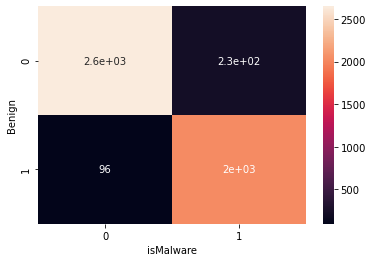

In [43]:
#Creating Confusion Matrix
conf_m = pd.crosstab(y_test, y_pred, rownames=['Benign'], colnames=['isMalware'])
sn.heatmap(conf_m, annot=True)

print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.show()

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2873
           1       0.90      0.95      0.93      2127

    accuracy                           0.94      5000
   macro avg       0.93      0.94      0.93      5000
weighted avg       0.94      0.94      0.94      5000



In [45]:
#Decision Tree 
dt=DecisionTreeClassifier()
dt.fit(x_train, y_train)
dt

DecisionTreeClassifier()

In [46]:
dt_pre=dt.predict(x_test)
print("Decision Tree Accuracy:",accuracy_score(dt_pre,y_test))
print("Confusion Matrix")
print(confusion_matrix(dt_pre,y_test))

Decision Tree Accuracy: 0.9992
Confusion Matrix
[[2871    2]
 [   2 2125]]
